In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import joblib

In [2]:
t0=time.time()

# Function to load a single file
def load_file(file_path):
    return np.loadtxt(file_path)

# List of file paths
file_paths = [
    r"/home/raman updated data/updated_Kont_D16_ZT6_2H_401_238.txt",
    r"/home/raman updated data/updated_Kont_D16_ZT6_8H_467_178.txt",
    r"/home/raman updated data/updated_Kont_D16_ZT6_16H.txt",
    r"/home/raman updated data/updated_SRBG_D16_ZT6_7H_445_176.txt",
    r"/home/raman updated data/updated_SRBG_ZT6_D16_3H_445_264.txt",
    r"/home/raman updated data/updated_SRBG_D16_ZT6_6H.txt"
]

# Parallel data loading
loaded_images = Parallel(n_jobs=-1)(delayed(load_file)(file_path) for file_path in file_paths)

# Unpack the loaded images if needed
cont_image1, cont_image2, cont_image3, srbg_image1, srbg_image2, srbg_image3 = loaded_images

t1=time.time()
t1-t0

48.51566028594971

In [3]:
cont_image1 = cont_image1.reshape(401,238,1000)
cont_image2 = cont_image2.reshape(467,178,1000)
cont_image3 = cont_image3.reshape(277,601,1000)
srbg_image1 = srbg_image1.reshape(445,176,1000)
srbg_image2 = srbg_image2.reshape(445,264,1000)
srbg_image3 = srbg_image3.reshape(396,334,1000)

In [4]:
images = [srbg_image1, srbg_image2, srbg_image3, cont_image1, cont_image2, cont_image3]

In [4]:
[srbg_image1.shape, srbg_image2.shape,srbg_image3.shape, cont_image1.shape, cont_image2.shape,cont_image3.shape]

[(445, 176, 1000),
 (445, 264, 1000),
 (396, 334, 1000),
 (401, 238, 1000),
 (467, 178, 1000),
 (277, 601, 1000)]

In [5]:
def percentile_outlier_to_zero_3d_nonzero(images, lower_percentile, upper_percentile):
    processed_images = []
    eliminated_spectra_per_image = []  # List to store the number of eliminated spectra for each image
    eliminated_locations_per_image = []  # List to store the locations of eliminated spectra for each image
    
    for image in images:
        # Create a mask that identifies nonzero vectors (any vector that is not entirely zeros)
        nonzero_mask = np.any(image != 0, axis=-1)
        
        # Compute the lower and upper percentiles along the last axis (spectra axis) for nonzero vectors
        lower_bound = np.percentile(image[nonzero_mask], lower_percentile, axis=0, keepdims=True)
        upper_bound = np.percentile(image[nonzero_mask], upper_percentile, axis=0, keepdims=True)
        
        # Create a mask for values that fall outside the percentile bounds
        outlier_mask = (image < lower_bound) | (image > upper_bound)
        
        # Copy the image to avoid modifying the original
        processed_image = np.copy(image)
        
        # Apply the mask and identify spectra with any outliers, but only for nonzero vectors
        mask_for_outliers_in_nonzero_vectors = np.any(outlier_mask & nonzero_mask[..., np.newaxis], axis=-1)
        
        # Zero out entire spectra that contain any outliers
        processed_image[mask_for_outliers_in_nonzero_vectors] = 0
        
        # Count the number of spectra (vectors) that had outliers eliminated (entire spectrum zeroed out)
        eliminated_spectra = np.sum(mask_for_outliers_in_nonzero_vectors)
        eliminated_spectra_per_image.append(eliminated_spectra)
        
        # Get the locations (indices) of eliminated spectra
        eliminated_locations = np.argwhere(mask_for_outliers_in_nonzero_vectors)
        eliminated_locations_per_image.append(eliminated_locations)
        
        # Append the processed image to the list
        processed_images.append(processed_image)
    
    return processed_images, eliminated_spectra_per_image, eliminated_locations_per_image

In [6]:
processed_images, eliminated_spectra_per_image, eliminated_locations_per_image = percentile_outlier_to_zero_3d_nonzero(images,
                                                                    lower_percentile=0.003, upper_percentile=99.997)

In [7]:
for i, (eliminated_spectra, eliminated_locations) in enumerate(zip(eliminated_spectra_per_image, eliminated_locations_per_image)):
    print(f"Image {i+1}: Number of spectra where outliers were eliminated: {eliminated_spectra}")
    print(f"Image {i+1}: Locations of eliminated spectra: {eliminated_locations}")

Image 1: Number of spectra where outliers were eliminated: 967
Image 1: Locations of eliminated spectra: [[  0  54]
 [  0  64]
 [  0  74]
 ...
 [441  94]
 [441 108]
 [441 112]]
Image 2: Number of spectra where outliers were eliminated: 1156
Image 2: Locations of eliminated spectra: [[  0  95]
 [  0 117]
 [  0 158]
 ...
 [443 229]
 [444 143]
 [444 259]]
Image 3: Number of spectra where outliers were eliminated: 788
Image 3: Locations of eliminated spectra: [[  0 181]
 [  0 190]
 [  0 236]
 ...
 [395 160]
 [395 209]
 [395 210]]
Image 4: Number of spectra where outliers were eliminated: 1071
Image 4: Locations of eliminated spectra: [[  0 123]
 [  0 129]
 [  0 195]
 ...
 [400 192]
 [400 193]
 [400 204]]
Image 5: Number of spectra where outliers were eliminated: 778
Image 5: Locations of eliminated spectra: [[ 93  92]
 [ 94  86]
 [ 94  94]
 ...
 [466  79]
 [466 106]
 [466 156]]
Image 6: Number of spectra where outliers were eliminated: 1459
Image 6: Locations of eliminated spectra: [[  0 2

In [9]:
images[5][0,127,:]

array([0.00333012, 0.00333012, 0.00333012, 0.00333012, 0.00435569,
       0.00637539, 0.0083951 , 0.0104148 , 0.01389982, 0.01746645,
       0.02103308, 0.02505079, 0.02977327, 0.03449574, 0.03921822,
       0.04185397, 0.04407853, 0.04630308, 0.04806291, 0.04865143,
       0.04923995, 0.04982847, 0.04907172, 0.04782953, 0.04658734,
       0.04550786, 0.04513245, 0.04475704, 0.04438162, 0.04630721,
       0.04950389, 0.05270058, 0.05582703, 0.05834919, 0.06087134,
       0.06339349, 0.06575222, 0.06798572, 0.07021923, 0.07226798,
       0.06840873, 0.06454948, 0.06069023, 0.05745356, 0.05484802,
       0.05224248, 0.04963694, 0.04890599, 0.04823747, 0.04756895,
       0.04817913, 0.05041918, 0.05265923, 0.05489928, 0.05474298,
       0.05436407, 0.05398516, 0.05234357, 0.04875889, 0.04517421,
       0.04158953, 0.03910819, 0.03678472, 0.03446124, 0.03366882,
       0.03562353, 0.03757824, 0.03953294, 0.04313247, 0.04703508,
       0.05093769, 0.05354352, 0.05355217, 0.05356081, 0.05356

In [10]:
processed_images[5][0,127,128]

0.0

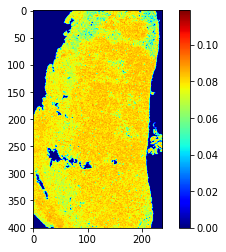

In [7]:
plt.imshow(processed_images[3][:,:,168], cmap='jet')
plt.colorbar()

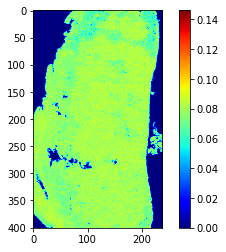

In [10]:
plt.imshow(cont_image1[:,:,168], cmap='jet')
plt.colorbar()

In [7]:
for i,data in enumerate(processed_images):
    mask = np.any(data != 0, axis=-1)
    filtered_data = data[mask]
    globals()["filtered_data_" + str(i)] = filtered_data.reshape(-1, data.shape[-1])

In [17]:
print(filtered_data_0.shape,filtered_data_1.shape,
filtered_data_2.shape,
filtered_data_3.shape,
filtered_data_4.shape,
filtered_data_5.shape)

(55391, 1000) (72228, 1000) (55824, 1000) (78061, 1000) (42229, 1000) (83989, 1000)


In [8]:
srbg_images=np.concatenate([filtered_data_0,filtered_data_1,filtered_data_2])
cont_images=np.concatenate([filtered_data_3,filtered_data_4,filtered_data_5])

In [11]:
srbg_images.shape

(182739, 1000)

In [9]:
x=np.arange(800,1800)
srbg_mean=np.mean(srbg_images,axis=0)
srbg_std=np.std(srbg_images,axis=0)
cont_mean=np.mean(cont_images,axis=0)
cont_std=np.std(cont_images,axis=0)

In [15]:
np.savetxt("raman_shift.txt", x)
np.savetxt("srbg_mean.txt", srbg_mean, header="srbg_mean", comments="", fmt="%.6f")
np.savetxt("srbg_std.txt", srbg_std, header="srbg_std", comments="", fmt="%.6f")
np.savetxt("cont_mean.txt", cont_mean, header="cont_mean", comments="", fmt="%.6f")
np.savetxt("cont_std.txt", cont_std, header="cont_std", comments="", fmt="%.6f")

['cont_std.txt']

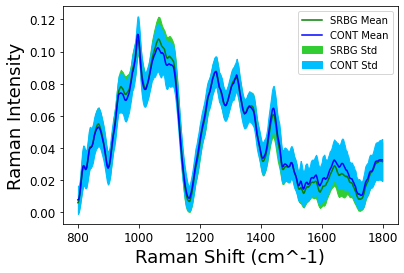

In [12]:
plt.plot(x,srbg_mean,'g',label='SRBG Mean')
plt.plot(x,cont_mean,'b',label='CONT Mean')
plt.fill_between(x, srbg_mean - srbg_std, srbg_mean + srbg_std, color='limegreen',label='SRBG Std')
plt.fill_between(x, cont_mean - cont_std, cont_mean + cont_std, color='deepskyblue',label='CONT Std')
plt.xlabel('Raman Shift (cm^-1)',fontsize=18)
plt.ylabel('Raman Intensity',fontsize=18)

plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=10)
#plt.savefig('spectrameanstd.svg', format='svg')
plt.show()

In [11]:
from scipy.signal import find_peaks
difference = srbg_mean-cont_mean
peaks, _ = find_peaks(difference)
deeps, _ = find_peaks(-difference)

In [12]:
filtered_peaks = [peak for peak in peaks if difference[peak] > 0.005]
filtered_deeps = [deep for deep in deeps if difference[deep] < -0.005]

In [13]:
filtered_deeps

[803, 808, 857, 868, 870]

In [14]:
filtered_peaks

[267, 286]

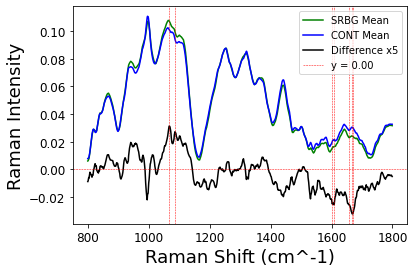

In [17]:
plt.plot(x,srbg_mean,'g',label='SRBG Mean')
plt.plot(x,cont_mean,'b',label='CONT Mean')
plt.plot(x,5*(srbg_mean-cont_mean),'black',label="Difference x5")
plt.axhline(y=0.00,color='red',linestyle='--',label='y = 0.00',linewidth=0.5)

for peak in filtered_peaks:
    plt.axvline(x=x[peak],color='red',linestyle='--',linewidth=0.5)
for deep in filtered_deeps:
    plt.axvline(x=x[deep],color='red', linestyle='--',linewidth=0.5)
    
plt.xlabel('Raman Shift (cm^-1)',fontsize=18)
plt.ylabel('Raman Intensity',fontsize=18)

plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=10)
plt.savefig('spectradifference.svg', format='svg')
plt.show()

In [13]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

n_wavenumbers = 1000

# Initialize an empty list to store p-values
p_values = []

# Perform Mann-Whitney U test for each wavenumber (feature index 0 to 999)
for i in np.array([267,286,803,857,868]):
    # Extract the data for the i-th wavenumber
    srbg_wavenumber = srbg_images[:, i]
    cont_wavenumber = cont_images[:, i]
    
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(srbg_wavenumber, cont_wavenumber, alternative='two-sided', method='asymptotic')    
    # Append the p-value to the list
    p_values.append(p_value)

In [14]:
# Convert the list of p-values to a numpy array for easier processing
p_values = np.array(p_values)

adjusted_p_values = multipletests(p_values, alpha=0.001, method='bonferroni')

# Extract the corrected p-values and the boolean array of significant results
corrected_p_values = adjusted_p_values[1]
significant_wavenumbers = np.where(adjusted_p_values[0])[0]

# Print the significant wavenumbers and their corrected p-values
for wavenumber in significant_wavenumbers:
    print(f"Wavenumber {800 + wavenumber}: corrected p-value = {corrected_p_values[wavenumber]} (significant)")

Wavenumber 800: corrected p-value = 0.0 (significant)
Wavenumber 801: corrected p-value = 0.0 (significant)
Wavenumber 802: corrected p-value = 0.0 (significant)
Wavenumber 803: corrected p-value = 0.0 (significant)
Wavenumber 804: corrected p-value = 0.0 (significant)


In [15]:
significant_wavenumbers.shape

(5,)

In [15]:
import pandas as pd
import seaborn as sns

In [16]:
# Create a DataFrame for easier plotting with seaborn
df = pd.DataFrame({
    'value': np.concatenate([cont_images[:,267], srbg_images[:,267],
                            cont_images[:,286], srbg_images[:,286],
                            cont_images[:,803], srbg_images[:,803],
                            cont_images[:,857], srbg_images[:,857],
                            cont_images[:,868], srbg_images[:,868]]),
    'group': ['1067 cm^-1'] * len(cont_images[:,267]) + ['1067 cm^-1'] * len(srbg_images[:,267]) + 
             ['1086 cm^-1'] * len(cont_images[:,286]) + ['1086 cm^-1'] * len(srbg_images[:,286]) +
             ['1603 cm^-1'] * len(cont_images[:,803]) + ['1603 cm^-1'] * len(srbg_images[:,803]) +
             ['1657 cm^-1'] * len(cont_images[:,857]) + ['1657 cm^-1'] * len(srbg_images[:,857]) +
             ['1668 cm^-1'] * len(cont_images[:,868]) + ['1668 cm^-1'] * len(srbg_images[:,868]),
                             
    'status': ['CONT'] * len(cont_images[:,267]) + ['SRBG'] * len(srbg_images[:,267]) + 
              ['CONT'] * len(cont_images[:,286]) + ['SRBG'] * len(srbg_images[:,286]) +
              ['CONT'] * len(cont_images[:,803]) + ['SRBG'] * len(srbg_images[:,803]) +
              ['CONT'] * len(cont_images[:,857]) + ['SRBG'] * len(srbg_images[:,857]) +
              ['CONT'] * len(cont_images[:,868]) + ['SRBG'] * len(srbg_images[:,868])
})

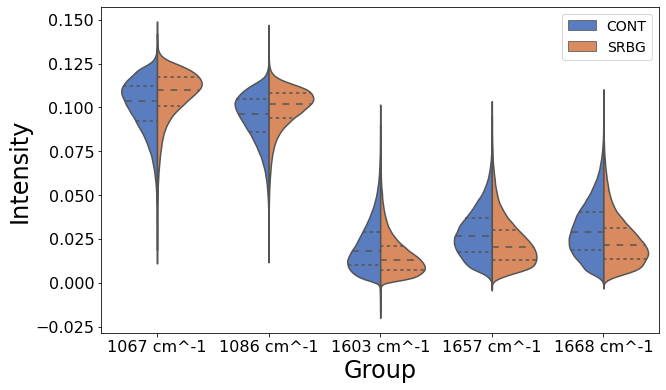

In [17]:
# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='group', y='value', hue='status', data=df, split=True, inner="quartile", palette="muted")
plt.xlabel('Group',fontsize=24)
plt.ylabel('Intensity',fontsize=24)

plt.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=14)
plt.savefig('violinplot.svg', format='svg')
plt.show()

In [18]:
def resize_image(image, target_rows, random_state=None):
    # Create a RandomState object for consistent randomness
    rng = np.random.RandomState(random_state)
    
    # Randomly select indices to keep using the provided random state
    indices_to_keep = rng.choice(image.shape[0], target_rows, replace=False)
    
    # Sort the indices to maintain the original order
    indices_to_keep.sort()
    
    # Return the resized image
    return image[indices_to_keep]

# Target shape
target_rows = min([filtered_data_0.shape[0], filtered_data_1.shape[0], filtered_data_2.shape[0],
                   filtered_data_3.shape[0], filtered_data_4.shape[0], filtered_data_5.shape[0]])

# Set a constant random state
random_state = 29

# Resize the images using the same random state for consistency
image0_resized = resize_image(filtered_data_0, target_rows, random_state=random_state)
image1_resized = resize_image(filtered_data_1, target_rows, random_state=random_state)
image2_resized = resize_image(filtered_data_2, target_rows, random_state=random_state)
image3_resized = resize_image(filtered_data_3, target_rows, random_state=random_state)
image4_resized = resize_image(filtered_data_4, target_rows, random_state=random_state)
image5_resized = resize_image(filtered_data_5, target_rows, random_state=random_state)



# Now all images should have the shape (40416, 1000)
print(image0_resized.shape)
print(image1_resized.shape)
print(image2_resized.shape)
print(image3_resized.shape)
print(image4_resized.shape)
print(image5_resized.shape)

(42229, 1000)
(42229, 1000)
(42229, 1000)
(42229, 1000)
(42229, 1000)
(42229, 1000)


In [9]:
images=np.concatenate((image0_resized,image1_resized,image2_resized,image3_resized,image4_resized,image5_resized))

In [14]:
images.shape[0]

253422

In [10]:
# Labels: 0 for control, 1 for pathologic
srbg_labels = np.ones(int(images.shape[0]/2))
cont_labels = np.zeros(int(images.shape[0]/2))

In [11]:
labels = np.concatenate((srbg_labels,cont_labels))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=57)

In [13]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [15]:
xgb_model = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.01,
    n_estimators=1000,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=10,
    reg_alpha=2,
    min_child_weight=7,
    eval_metric='logloss'
)

cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy', verbose=1)

# Print cross-validation results
print(f"Cross-Validation Accuracy Scores: {cv_scores_xgb}")
print(f"Mean Accuracy: {cv_scores_xgb.mean():.4f}")
print(f"Standard Deviation: {cv_scores_xgb.std():.4f}")

Cross-Validation Accuracy Scores: [0.68071041 0.68300444 0.67794771 0.67861371 0.68319396]
Mean Accuracy: 0.6807
Standard Deviation: 0.0022


In [14]:
import joblib

In [16]:
joblib.dump(cv_scores_xgb, 'cv_scores_xgb_1.pkl')

['cv_scores_xgb_1.pkl']

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [13]:
lda = LinearDiscriminantAnalysis()

cv_scores_lda = cross_val_score(lda, X_train, y_train, cv=5, scoring='accuracy')

for fold, score in enumerate(cv_scores_lda, 1):
    print(f"Fold {fold} Accuracy: {score:.4f}")

mean_cv_accuracy_lda = np.mean(cv_scores_lda)
print(f"\nMean Cross-Validation Accuracy: {mean_cv_accuracy_lda:.4f}")

Fold 1 Accuracy: 0.8008
Fold 2 Accuracy: 0.8044
Fold 3 Accuracy: 0.8025
Fold 4 Accuracy: 0.8028
Fold 5 Accuracy: 0.8027

Mean Cross-Validation Accuracy: 0.8027


In [14]:
joblib.dump(cv_scores_lda, 'cv_scores_lda_1.pkl')

['cv_scores_lda_1.pkl']

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [16]:
mlp = MLPClassifier(
    hidden_layer_sizes=(10,) * 10,
    activation='relu',
    alpha=0.0001,
    random_state=34,
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=5,
    tol=1e-4
)

cv_scores_mlp = cross_val_score(mlp, X_train_scaled, y_train, cv=5, scoring='accuracy')

for fold, score in enumerate(cv_scores_mlp, 1):
    print(f"Fold {fold} Accuracy: {score:.4f}")

mean_cv_accuracy_mlp = np.mean(cv_scores_mlp)
print(f"\nMean Cross-Validation Accuracy: {mean_cv_accuracy_mlp:.4f}")

Fold 1 Accuracy: 0.7667
Fold 2 Accuracy: 0.7657
Fold 3 Accuracy: 0.7688
Fold 4 Accuracy: 0.7668
Fold 5 Accuracy: 0.7681

Mean Cross-Validation Accuracy: 0.7672


In [17]:
joblib.dump(cv_scores_mlp, 'cv_scores_mlp_1.pkl')

['cv_scores_mlp_1.pkl']

In [18]:
xgb_pretrained = xgb.XGBClassifier(
    max_depth=4,
    learning_rate=0.01,
    n_estimators=1000,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=10,           
    reg_alpha=2,             
    min_child_weight=7,     
    eval_metric='logloss'
)

xgb_pretrained.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-logloss:0.69234
[1]	validation_0-logloss:0.69153
[2]	validation_0-logloss:0.69075
[3]	validation_0-logloss:0.68997
[4]	validation_0-logloss:0.68923
[5]	validation_0-logloss:0.68848
[6]	validation_0-logloss:0.68774
[7]	validation_0-logloss:0.68703
[8]	validation_0-logloss:0.68633
[9]	validation_0-logloss:0.68564
[10]	validation_0-logloss:0.68495
[11]	validation_0-logloss:0.68427
[12]	validation_0-logloss:0.68359
[13]	validation_0-logloss:0.68295
[14]	validation_0-logloss:0.68233
[15]	validation_0-logloss:0.68170
[16]	validation_0-logloss:0.68107
[17]	validation_0-logloss:0.68046
[18]	validation_0-logloss:0.67985
[19]	validation_0-logloss:0.67926
[20]	validation_0-logloss:0.67866
[21]	validation_0-logloss:0.67807
[22]	validation_0-logloss:0.67749
[23]	validation_0-logloss:0.67694
[24]	validation_0-logloss:0.67637
[25]	validation_0-logloss:0.67581
[26]	validation_0-logloss:0.67528
[27]	validation_0-logloss:0.67475
[28]	validation_0-logloss:0.67422
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [20]:
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(10,)*10, activation='relu', alpha=0.0001, random_state=34, max_iter=200,
                          early_stopping=True, validation_fraction=0.2, n_iter_no_change=5, tol=1e-4))
])

lda_model = LinearDiscriminantAnalysis()

In [21]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [22]:
t0=time.time()

meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=[('xgb', xgb_pretrained), ('mlp', mlp_pipeline), ('lda', lda_model)],
    final_estimator=meta_model,
    cv=5
)

# Fit stacking model on the data
stacking_model.fit(X_train, y_train)

t1=time.time()
t1-t0
joblib.dump(stacking_model, 'stacking_model2957_1.h5')

['stacking_model2957_1.h5']

In [23]:
train_accuracy_stk = stacking_model.score(X_train, y_train)
print(f"Stacking Model Train Accuracy: {train_accuracy_stk:.4f}")
test_accuracy_stk = stacking_model.score(X_test, y_test)
print(f"Stacking Model Test Accuracy: {test_accuracy_stk:.4f}")

Stacking Model Train Accuracy: 0.8172
Stacking Model Test Accuracy: 0.8121


In [24]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define the model creation function
def create_tf_model():
    model = Sequential()
    model.add(Input(shape=(1000,)))  # Input layer with 1000 features
    
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0004)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0004)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))          
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store accuracy for each fold
fold_accuracies = []

# Start cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
    print(f"\nTraining fold {fold + 1}...")
    
    # Split data into training and validation sets for the fold
    X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Create a new instance of the model for each fold
    model = create_tf_model()
    
    # Train the model with validation data for early stopping
    history = model.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=1000,
        batch_size=16,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate the model on the validation data
    val_accuracy = model.evaluate(X_fold_val, y_fold_val, verbose=0)[1]
    fold_accuracies.append(val_accuracy)
    print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy:.4f}")

# Calculate and print the average accuracy across all folds
average_accuracy_tf = np.mean(fold_accuracies)
print(f"\nAverage Cross-Validation Accuracy: {average_accuracy_tf:.4f}")

# Save the final model from the last fold (optional)
model.save("final_model_last_fold_1.h5")
joblib.dump(fold_accuracies, 'fold_accuracies_1.pkl')


Training fold 1...
Epoch 1/1000
10135/10135 [==============================] - 11s 1ms/step - loss: 0.6563 - accuracy: 0.6641 - val_loss: 0.5961 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 2/1000
10135/10135 [==============================] - 10s 1ms/step - loss: 0.6277 - accuracy: 0.6790 - val_loss: 0.6028 - val_accuracy: 0.6976 - lr: 0.0010
Epoch 3/1000
10135/10135 [==============================] - 10s 1ms/step - loss: 0.6239 - accuracy: 0.6802 - val_loss: 0.5915 - val_accuracy: 0.7044 - lr: 0.0010
Epoch 4/1000
10135/10135 [==============================] - 10s 1ms/step - loss: 0.6219 - accuracy: 0.6804 - val_loss: 0.5926 - val_accuracy: 0.7037 - lr: 0.0010
Epoch 5/1000
10135/10135 [==============================] - 10s 1ms/step - loss: 0.6175 - accuracy: 0.6836 - val_loss: 0.5810 - val_accuracy: 0.7089 - lr: 0.0010
Epoch 6/1000
10135/10135 [==============================] - 10s 1ms/step - loss: 0.6162 - accuracy: 0.6831 - val_loss: 0.5817 - val_accuracy: 0.7072 - lr: 0.0010
Epoch 7/

/home/root/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['fold_accuracies_1.pkl']

In [27]:
stacking_model = joblib.load('stacking_model2957_1.h5')
cv_accuracy_tf = np.mean(joblib.load('fold_accuracies_1.pkl'))
cv_scores_xgb = joblib.load('cv_scores_xgb_1.pkl')
cv_scores_lda = joblib.load('cv_scores_lda_1.pkl')
cv_scores_mlp = joblib.load('cv_scores_mlp_1.pkl')

In [28]:
cv_accuracy_stk = stacking_model.score(X_test, y_test)
cv_accuracy_xgb = cv_scores_xgb.mean()
cv_accuracy_lda = cv_scores_lda.mean()
cv_accuracy_mlp = cv_scores_mlp.mean()

In [29]:
np.mean(joblib.load('fold_accuracies_1.pkl'))

0.7713802337646485

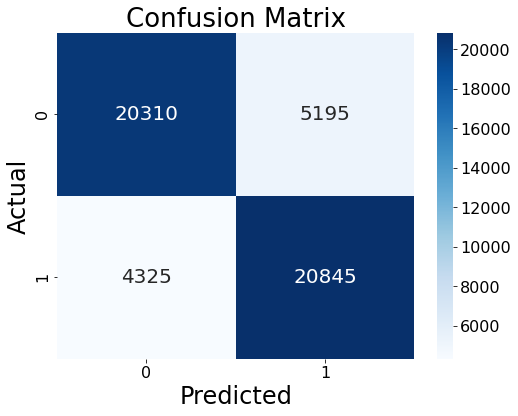

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = stacking_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary classes

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',annot_kws={"size": 20})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.xlabel('Predicted', fontsize=24)
plt.ylabel('Actual', fontsize=24)
plt.title('Confusion Matrix', fontsize=26)

plt.tick_params(axis='both', labelsize=16)
plt.savefig('confusion_matrix.svg', format='svg')
plt.show()

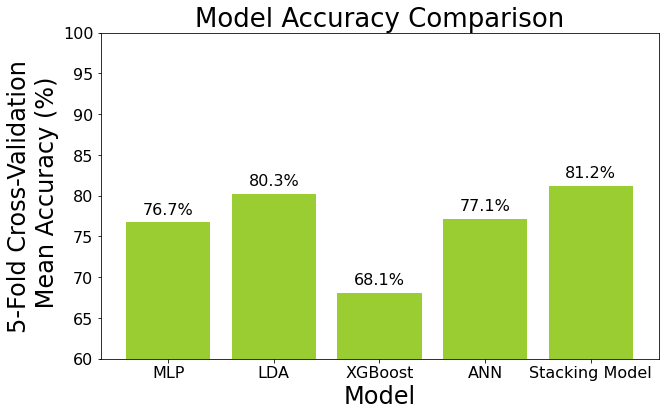

In [31]:
accuracies = [cv_accuracy_mlp, cv_accuracy_lda, cv_accuracy_xgb, cv_accuracy_tf, cv_accuracy_stk]
model_names = ['MLP', 'LDA', 'XGBoost', 'ANN', 'Stacking Model']

# Convert accuracies to percentages
accuracies_percent = [accuracy * 100 for accuracy in accuracies]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies_percent, color='yellowgreen')
plt.xlabel('Model', fontsize=24)
plt.ylabel('5-Fold Cross-Validation\n Mean Accuracy (%)', fontsize=24)
plt.title('Model Accuracy Comparison', fontsize=26)
plt.ylim(60, 100)

for i, accuracy in enumerate(accuracies_percent):
    plt.text(i, accuracy + 1, f'{accuracy:.1f}%', ha='center', fontsize=16)

plt.tick_params(axis='both', labelsize=16)
plt.savefig('cvcomparison.svg', format='svg')
plt.show()

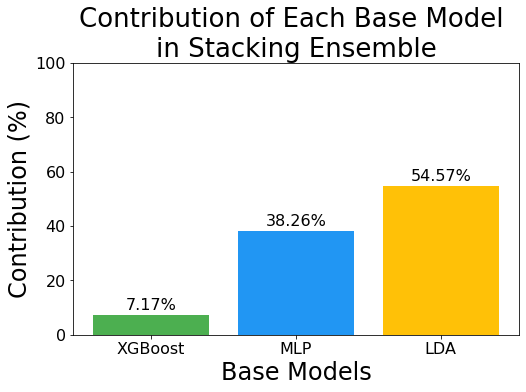

In [32]:
coefficients = np.abs(stacking_model.final_estimator_.coef_[0])
total = np.sum(coefficients)

# Calculate the percentage contribution of each model
percentages = (coefficients / total) * 100
model_names = ['XGBoost', 'MLP', 'LDA']

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(model_names, percentages, color=['#4CAF50', '#2196F3', '#FFC107'])
plt.xlabel('Base Models', fontsize=24)
plt.ylabel('Contribution (%)', fontsize=24)
plt.title('Contribution of Each Base Model \nin Stacking Ensemble', fontsize=26)
plt.ylim(0, 100)

# Display the percentage value on top of each bar
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 2, f"{percentage:.2f}%", ha='center', fontsize=16)

plt.tick_params(axis='both', labelsize=16)
plt.savefig('ensemblecontributions.svg', format='svg')
plt.show()

In [33]:
from sklearn.metrics import roc_curve, auc

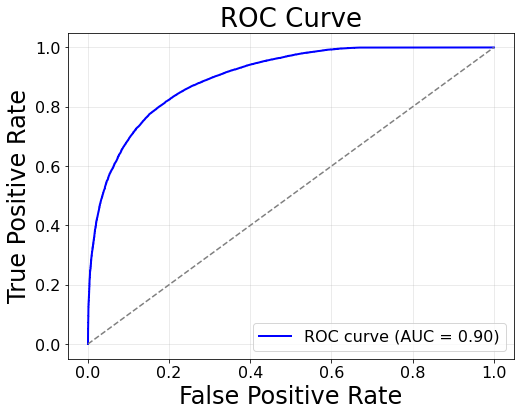

In [34]:
y_prob = stacking_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.title('ROC Curve', fontsize=26)

plt.legend(loc='lower right', fontsize=16)
plt.grid(alpha=0.3)

plt.tick_params(axis='both', labelsize=16)
plt.savefig('roc.svg', format='svg')
plt.show()

In [36]:
joblib.dump(stacking_model, 'stacking_model2957_1.h5') #2957

['stacking_model2957_1.h5']

In [37]:
loaded_model = joblib.load('stacking_model2957_1.h5')

In [38]:
loaded_model.score(X_test, y_test)

0.8121361618154909